In [18]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.input_area pre {font-family: Consolas; font-size: 16pt; line-height: 140%;}</style>"))
display(HTML("<style>.output_area pre {font-family: Consolas; font-size: 16pt; line-height: 140%;}</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import os
import glob
import datetime
import shutil
from collections import defaultdict, Counter
from copy import deepcopy
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

import matplotlib.patches as mpatches
import math

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import statsmodels.stats.multitest as multest
import seaborn as sns
import scipy.stats as sci

# CRISPR

In [7]:
def get_SigTT(cell, tp):
    sigTT=pd.read_table('result/sig_TT&TCP/sig_TT.txt', sep='\t',index_col=0,header=None, engine='python')
    sigTT=sigTT.loc['{}({})'.format(cell,tp)].iloc[1].split(',')
    return set(sigTT)

def eval_crispr(cell, CCG_FDR, res_file):
    TTS_both=pd.read_table('result/TTscore/TTS_both.txt', sep='\t',index_col=0,engine='python')
    allTF=set(TTS_both.index)

    CCG=pd.read_table('data/CRISPR/GeckoV2_{}.txt'.format(cell), sep='\t',index_col=0,engine='python')
    CCG=set(CCG.loc[CCG['FDR']<CCG_FDR].index)
    CCG=CCG&allTF

    sigNegTT = get_SigTT(cell,'neg')

    sigNegTT=sigNegTT&allTF
    p_val = sci.hypergeom.sf(len(sigNegTT&CCG), len(allTF), len(CCG), len(sigNegTT))
    res_file.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(cell,CCG_FDR, len(allTF), len(CCG), len(sigNegTT), len(sigNegTT&CCG), p_val, sigNegTT&CCG))
    
    return p_val

def draw_pval_CRISPR(ax, fdr_list, color_list):
    res_file=open('result/Eval/CRISPR_hyper_result.txt','w+')
    res_file.write('cell\tFDR\tALL\tCRISPR\tNegTT\tHIT\tP-val\thit_TF_list\n')
    
    for cell, y_start  in [('A375',0),('HT29', 5)]:
        pVal_list=[]
        for FDR in fdr_list:
            pVal=eval_crispr(cell, FDR, res_file)
            pVal_list.append(pVal)

        x_list=np.arange(y_start,y_start+4)
        pValLog_list=[-np.log10(p_val) for p_val in pVal_list]

        ax.bar(x_list, pValLog_list, color=color_list, width=1, edgecolor='k')
            
    res_file.close()

# TTD

In [8]:
def get_TTD():
    def cancer_related_disease(x):
        code_list=[]
        for code in x.split(', '):
            code_list+=code.split('-')

        for code in code_list:
            if code.startswith('C') or code.startswith('D') :
                return True
        return False

    TTD_to_UPT=pd.read_table('data/TTD/P2-01-TTD_uniprot_all.txt', index_col=0, sep='\t',engine='python')
    TTD_to_UPT=TTD_to_UPT['Uniprot ID'].map(lambda x: x.split(' ')[0]).to_dict()
    UPT_to_gene=pd.read_table('data/TTD/uniprot_to_gene.txt', index_col=0, sep='\t',engine='python')
    UPT_to_gene=UPT_to_gene['To'].to_dict()

    ##
    TTD_TarDis=pd.read_table('data/TTD/P1-05-Target_disease.txt', sep='\t',engine='python')
    TTD_TarDis=TTD_TarDis.loc[TTD_TarDis['ICD10'].notnull()]
    TTD_TarDis=TTD_TarDis.loc[TTD_TarDis['ICD10'].map(cancer_related_disease)]

    ##
    TTD_available_UPT=set(TTD_TarDis['TTDTargetID'])&set(TTD_to_UPT.keys())

    UPT_list=[]
    for TTD in TTD_available_UPT:
        UPT_list.append(TTD_to_UPT[TTD])

    UPT_available_gene=set(UPT_list)&set(UPT_to_gene.keys())

    gene_list=[]
    for UPT in UPT_available_gene:
        gene_list.append(UPT_to_gene[UPT])

    return set(gene_list)

    
def draw_pval_TTD(ax,space):
    res_file=open('result/Eval/TTD_hyper_result.txt','w+')
    res_file.write('cell\tALL\tTTD\tNegTT\tHIT\tP-val\thit_TF_list\n')

    TTS_both=pd.read_table('result/TTscore/TTS_both.txt', sep='\t',index_col=0,engine='python')
    allTF=set(TTS_both.index)

    CCG=get_TTD()
    CCG=CCG&allTF

    pVal_list=[]
    for cell in ['A375','HT29','both']:
        print('####', cell)
        OCTT= get_SigTT(cell,'neg')

        OCTT=OCTT&allTF
        p_val = sci.hypergeom.sf(len(OCTT&CCG), len(allTF), len(CCG), len(OCTT))
        res_file.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(cell, len(allTF), len(CCG), len(OCTT), len(OCTT&CCG), p_val, OCTT&CCG))
        pVal_list.append(p_val)

    ## bar plot
    x_list=np.arange(3)
    y_list=[-np.log10(p_val) for p_val in pVal_list]

    ax.bar(x_list+space, y_list, color='lightpink', edgecolor='black', width=0.2)


    res_file.close()

# TSgene

In [9]:
def draw_pval_TSgene(ax,space):
    TTS_both=pd.read_table('result/TTscore/TTS_both.txt', sep='\t',index_col=0,engine='python')
    allTF=set(TTS_both.index)

    TSG=pd.read_table('data/TSgene2.0/Human_TSGs.txt', sep='\t',index_col=0,engine='python')
    TSG=set(TSG['GeneSymbol'])
    TSG=allTF&TSG

    res_file=open('result/Eval/TSgene_hyper_result.txt','w+')
    res_file.write('cell\tALL\tTSgene\tPosTT\tHIT\tP-val\thit_TF_list\n')

    pVal_list=[]
    for cell in ['A375','HT29','both']:
        sigPosTT=get_SigTT(cell,'pos')
        sigPosTT=sigPosTT&allTF

        p_val = sci.hypergeom.sf(len(sigPosTT&TSG), len(allTF), len(TSG), len(sigPosTT))
        res_file.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(cell, len(allTF), len(TSG), len(sigPosTT), len(sigPosTT&TSG), p_val, sigPosTT&TSG))
        pVal_list.append(p_val)

    res_file.close()

    ## bar plot
    x_list=np.arange(3)
    y_list=[-np.log10(p_val) for p_val in pVal_list]

    ax2.bar(x_list+space, y_list, color='lightcyan', edgecolor='black',width=0.2)

# uniprot

In [10]:
def draw_pval_uniprot(status,ax,space):
    TTS_both=pd.read_table('result/TTscore/TTS_both.txt', sep='\t',index_col=0,engine='python')
    allTF=set(TTS_both.index)
    
    
    CCG_list=[]
    CCG=pd.read_table('data/Uniprot/{}_uniprot.txt'.format(status), sep='\t',engine='python')
    CCG=CCG.loc[CCG['Gene names'].notnull()]

    for ind, row in CCG.iterrows():
        CCG_list+=row['Gene names'].split(' ')

    CCG=set(CCG_list)
    CCG=allTF&CCG

    res_file=open('result/Eval/uniprot_{}_hyper_result.txt'.format(status),'w+')
    res_file.write('cell\tALL\tuniprot({})\tPosTT\tHIT\tP-val\thit_TF_list\n'.format(status))
    
    pVal_list=[]
    for cell in ['A375','HT29','both']:
        if status=='oncogene':
            sigTT = get_SigTT(cell,'neg')
        if status=='Tumor_suppressor':
            sigTT = get_SigTT(cell,'pos')

        sigTT=sigTT&allTF
        p_val = sci.hypergeom.sf(len(sigTT&CCG), len(allTF), len(CCG), len(sigTT))
        
        res_file.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(cell, len(allTF), len(CCG), len(sigTT), len(sigTT&CCG), p_val, sigTT&CCG))
        pVal_list.append(p_val)

    res_file.close()

    ## bar plot
    x_list=np.arange(3)
    y_list=[-np.log10(p_val) for p_val in pVal_list]
    
    if status=='oncogene':
        ax2.bar(x_list+space, y_list, color='lavender', edgecolor='black',width=0.2)
    if status=='Tumor_suppressor':
        ax2.bar(x_list+space, y_list, color='lavender', hatch='////',edgecolor='black',width=0.2)

# draw all figure (main)

[Text(0, 0, 'A375'), Text(0, 0, 'HT29')]

Text(0, 0.5, '-log10(p-value)')

Text(0.5, 1.0, 'CRISPR')

(-1, 10.2)

Text(8.8, 1.3010299956639813, '0.05')

Text(8.8, 2.0, '0.01')

Text(8.8, 2.3010299956639813, '0.005')

Text(8.8, 3.0, '0.001')

#### A375
#### HT29
#### both


[Text(0, 0, 'A375'), Text(0, 0, 'HT29'), Text(0, 0, 'both')]

Text(0, 0.5, '-log10(p-value)')

Text(0.5, 1.0, 'TTD, TSgene and Uniprot')

(-0.3, 3.15)

Text(2.8, 1.3010299956639813, '0.05')

Text(2.8, 2.0, '0.01')

Text(0.02, 0.95, '(a)')

Text(0.02, 0.47, '(b)')

C:\Users\jmjung\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


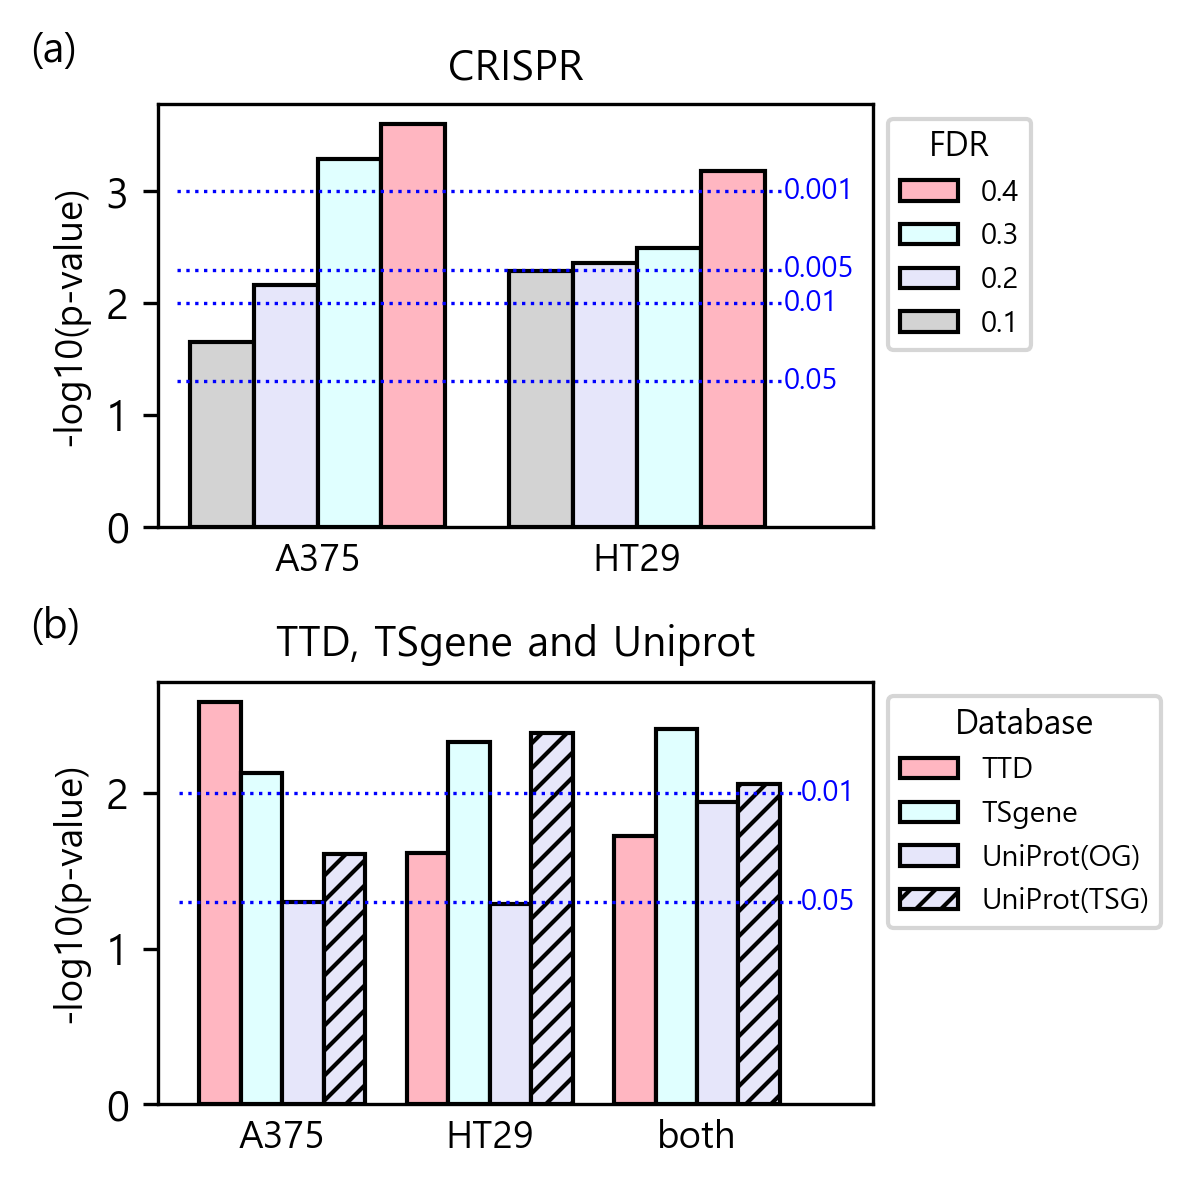

In [57]:
fig=plt.figure(figsize=(4,4), dpi=300)
ax1=fig.add_subplot(2,1,1)
ax2=fig.add_subplot(2,1,2)

## ax1
fdr_list=[0.1,0.2,0.3,0.4]
color_list=['lightgray','lavender','lightcyan','lightpink']
draw_pval_CRISPR(ax1, fdr_list, color_list)
# ticks
ax1.set_xticks([1.5,6.5])
ax1.set_xticklabels(['A375', 'HT29'], fontsize=9)
ax1.set_ylabel('-log10(p-value)', fontsize=9)
ax1.set_title('CRISPR', fontsize=10)
ax1.tick_params('x',which='both', length=0.0)
# legend
patch_list=[]
for ii in range(4):
    patch_list.append(mpatches.Patch(facecolor=color_list[::-1][ii], edgecolor='k', label=fdr_list[::-1][ii]))

ax1.legend(handles=patch_list, title='FDR',title_fontsize=8,loc='upper left', fontsize=7, bbox_to_anchor=(1.0,1.0))
ax1.set_xlim(-1,10.2)

ax1.plot([-0.7,8.8],[-np.log10(0.05),-np.log10(0.05)], color='blue', lw=0.8, ls=':')
ax1.plot([-0.7,8.8],[-np.log10(0.01),-np.log10(0.01)], color='blue', lw=0.8, ls=':')
ax1.plot([-0.7,8.8],[-np.log10(0.005),-np.log10(0.005)], color='blue', lw=0.8, ls=':')
ax1.plot([-0.7,8.8],[-np.log10(0.001),-np.log10(0.001)], color='blue', lw=0.8, ls=':')

ax1.text(8.8,-np.log10(0.05), '0.05',  ha='left', va='center',fontsize=7, color='b')
ax1.text(8.8,-np.log10(0.01), '0.01',  ha='left', va='center',fontsize=7, color='b')
ax1.text(8.8,-np.log10(0.005),'0.005', ha='left', va='center',fontsize=7, color='b')
ax1.text(8.8,-np.log10(0.001),'0.001', ha='left', va='center',fontsize=7, color='b')


## ax2
draw_pval_TTD(ax2,0)
draw_pval_TSgene(ax2,0.2)
draw_pval_uniprot('oncogene',ax2,0.4)
draw_pval_uniprot('Tumor_suppressor', ax2,0.6)
# ticks
ax2.set_xticks([0.3,1.3,2.3])
ax2.set_xticklabels(['A375','HT29','both'], fontsize=9)
ax2.set_ylabel('-log10(p-value)', fontsize=9)
ax2.set_title('TTD, TSgene and Uniprot', fontsize=10)
ax2.tick_params('x',which='both', length=0.0)
## legend
patch_list=[]
for ii in range(4):
    if ii!=3:
        patch_list.append(mpatches.Patch(facecolor=['lightpink','lightcyan','lavender'][ii], edgecolor='k', label=['TTD','TSgene','UniProt(OG)'][ii]))
    else:
        patch_list.append(mpatches.Patch(facecolor='lavender', edgecolor='k', hatch='////', label='UniProt(TSG)'))

ax2.legend(handles=patch_list, title='Database',title_fontsize=8, loc='upper left', fontsize=7, bbox_to_anchor=(1.0,1.0))
ax2.set_xlim(-0.3,3.15)

ax2.plot([-0.2,2.8],[-np.log10(0.05),-np.log10(0.05)], color='blue', lw=0.8, ls=':')
ax2.plot([-0.2,2.8],[-np.log10(0.01),-np.log10(0.01)], color='blue', lw=0.8, ls=':')

ax2.text(2.8,-np.log10(0.05), '0.05',  ha='left', va='center',fontsize=7, color='b')
ax2.text(2.8,-np.log10(0.01), '0.01',  ha='left', va='center',fontsize=7, color='b')

fig.text(0.02,0.95,'(a)', fontsize=10)
fig.text(0.02,0.47,'(b)', fontsize=10)
fig.tight_layout()
fig.show()